# Luderick Object Detection Using Pytorch Faster R-CNN

## Load the preprocessed DataFrames generated in the preprocessing Notebook

In [3]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

plt.style.use('ggplot')

In [4]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array
    """
    loaded_df = pd.read_csv(file_path)
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [5]:
train_df = load_luderick_df('luderick_train_preprocessed.csv')
validation_df = load_luderick_df('luderick_validation_preprocessed.csv')

train_df

,image_name,video_name,frame_number,number_boxes,labels,bounding_boxes,area,segmentation
0,04C1_Luderick_1.mov_5fps_000001.jpg,04C1_Luderick_1,1,1,[1],"[[1778, 425, 1919, 610]]",[26085],"[[1778, 515, 1789, 498, 1806, 479, 1835, 457, ..."
1,04C1_Luderick_1.mov_5fps_000002.jpg,04C1_Luderick_1,2,1,[1],"[[1659, 406, 1919, 645]]",[62140],"[[1659, 509, 1675, 488, 1696, 465, 1720, 437, ..."
2,04C1_Luderick_1.mov_5fps_000003.jpg,04C1_Luderick_1,3,1,[1],"[[1578, 400, 1915, 620]]",[74140],"[[1578, 530, 1585, 512, 1594, 496, 1592, 477, ..."
3,04C1_Luderick_1.mov_5fps_000004.jpg,04C1_Luderick_1,4,1,[1],"[[1508, 398, 1812, 626]]",[69312],"[[1812, 624, 1795, 578, 1795, 542, 1797, 507, ..."
4,04C1_Luderick_1.mov_5fps_000005.jpg,04C1_Luderick_1,5,1,[1],"[[1465, 390, 1699, 626]]",[55224],"[[1691, 591, 1687, 544, 1688, 503, 1691, 473, ..."
...,...,...,...,...,...,...,...,...
2667,C4_Luderick_9_014000.jpg,C4_Luderick_9,21,1,[1],"[[471, 127, 699, 360]]",[53124],"[[471, 360, 491, 319, 492, 280, 487, 236, 489,..."
2668,C4_Luderick_9_014200.jpg,C4_Luderick_9,22,1,[1],"[[561, 79, 829, 313]]",[62712],"[[578, 313, 592, 247, 618, 252, 656, 230, 679,..."
2669,C4_Luderick_9_014400.jpg,C4_Luderick_9,23,1,[1],"[[573, 33, 971, 261]]",[90744],"[[578, 261, 594, 213, 601, 183, 594, 146, 581,..."
2670,C4_Luderick_9_014600.jpg,C4_Luderick_9,24,1,[1],"[[650, 3, 1126, 216]]",[101388],"[[650, 216, 676, 182, 673, 133, 674, 90, 673, ..."


## Configuration

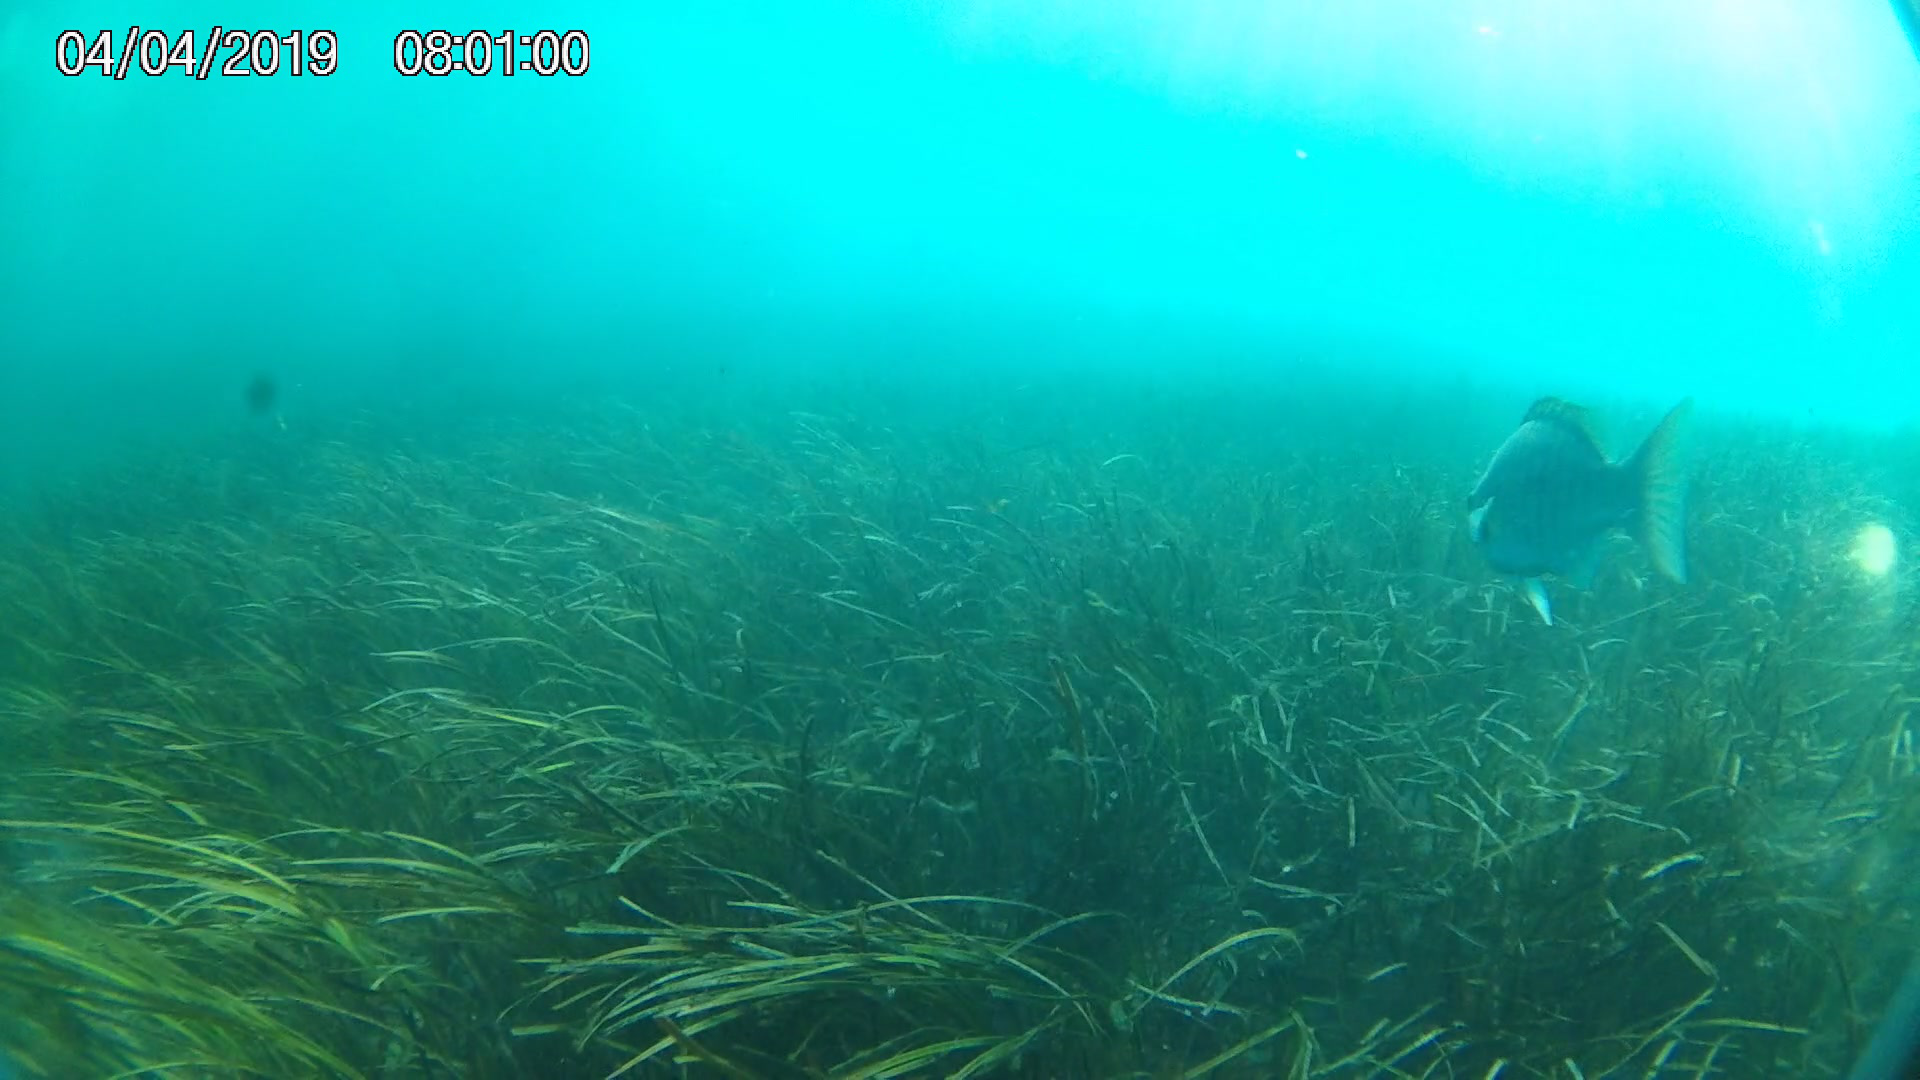

In [6]:
Image.open("Fish_automated_identification_and_counting/luderick-seagrass/04C1_Luderick_1.mov_5fps_000005.jpg")

In [7]:
BATCH_SIZE = 2 # increase / decrease according to GPU memeory
MAX_SIZE = 512 # resize the image for training and transforms
NUM_EPOCHS = 20 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory

IMAGES_DIR = "Fish_automated_identification_and_counting/luderick-seagrass"

# classes: 0 index is reserved for background
CLASSES = [
    'background', 'Arduino_Nano', 'ESP8266', 'Raspberry_Pi_3', 'Heltec_ESP32_Lora'
]
NUM_CLASSES = len(CLASSES)

# location to save model and plots
OUT_DIR = 'faster_rcnn_outputs'
!mkdir {OUT_DIR}
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

Ya existe el subdirectorio o el archivo faster_rcnn_outputs.


## Utility and helper functions

In [8]:
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
        
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), model_name='model'
    ):
        self.best_valid_loss = best_valid_loss
        self.model_name = model_name
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{OUT_DIR}/best_model_{self.model_name}_epoch_{epoch+1}.pth')

In [9]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number of objects
    and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [10]:
def save_model(epoch, model, optimizer, model_name='model'):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{OUT_DIR}/last_model_{model_name}_epoch_{epoch+1}.pth')


In [11]:
def save_loss_plot(output_dir, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{output_dir}/train_loss.png")
    figure_2.savefig(f"{output_dir}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    
    plt.close('all')

In [12]:
def view_dataset_image(image):
    """
    View an image from the dataset returned format and return it as PIL Image
    """
    image = np.array(image.cpu()).transpose(1, 2, 0)
    return Image.fromarray((image*255).astype(np.uint8))

## Transform functions

In [13]:
# define the training transforms
def get_train_transform(image):
    # bring color channels to front (shape (600, 800, 3) to (3, 600, 800)), the model wants the channels dimension first
    image = torch.from_numpy(image.transpose(2, 0, 1))
    return image

# define the validation transforms
def get_valid_transform(image):
    image = torch.from_numpy(image.transpose(2, 0, 1))
    return image

## The Dataset Class

In [14]:
class LuderickDataset(torch.utils.data.Dataset):
    def __init__(self, luderick_df, images_dir, classes, max_size=None, transforms=None):
        self.luderick_df = luderick_df
        self.images_dir = images_dir
        self.max_size = max_size
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, idx):
        # load images and masks
        row = self.luderick_df.iloc[idx]
        image_path = os.path.join(self.images_dir, row['image_name'])
        
        #read the image
        image = cv2.imread(image_path)
        #image = Image.open(image_path)

        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        resize_ratio = 1
        if self.max_size:
            height, width, _ = image.shape
            max_dim = max(height, width)
            resize_ratio = self.max_size / max_dim
            image = cv2.resize(image, (int(width*resize_ratio), int(height*resize_ratio)))
            
        image /= 255.0
        
        num_boxes = row['number_boxes']
        boxes = row['bounding_boxes']
        labels = row['labels']
        area = row['area']
        
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = torch.as_tensor(area, dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_boxes,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes*resize_ratio # resize bounding box coordinates according to the image resizing
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area*resize_ratio**2 # ratio*h*ratio*w = h*w*ratio^2
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.luderick_df)

In [15]:
# create the dataset instances
train_dataset = LuderickDataset(train_df, IMAGES_DIR, CLASSES, MAX_SIZE, get_train_transform)
valid_dataset = LuderickDataset(validation_df, IMAGES_DIR, CLASSES, MAX_SIZE, get_valid_transform)

(512, 288)


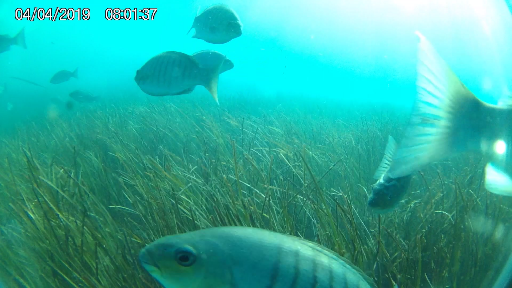

In [18]:
# check one example
image, target = train_dataset[90]
# check that the resizing was correct
image = view_dataset_image(image)
print(image.size)
display(image)

In [19]:
# visualize the bounding boxes data and how it got resized accordingly
target

{'boxes': tensor([[134.6667, 221.3333, 380.5334, 286.6667],
         [361.6000, 132.2667, 416.0000, 209.6000],
         [381.6000,  23.2000, 509.6000, 200.0000],
         [183.4667,   4.8000, 244.0000,  45.8667],
         [129.8667,  47.2000, 230.4000, 110.6667],
         [ 46.9333,  65.0667,  79.7333,  85.0667],
         [  0.0000,  22.6667,  29.3333,  54.1333]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
 'image_id': tensor([90]),
 'area': tensor([16063.2891,  4206.9336, 22630.4004,  2485.9023,  6380.5156,   656.0000,
           923.0222]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0])}

## Create the data loaders

In [20]:
train_loader = DataLoader(train_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True, # shuffle the dataset to avoid overfitting on long sequences
                         num_workers=0,
                         collate_fn=collate_fn)

valid_loader = DataLoader(valid_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         collate_fn=collate_fn)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 2672
Number of validation samples: 824



Batch size: 2
(512, 288)


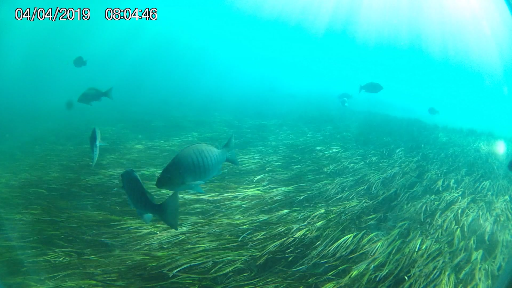

In [23]:
# get one batch of images and targets
image, target = next(iter(train_loader))
# check the batch size
print(f'Batch size: {len(image)}')
# display the first image
image = view_dataset_image(image[0])
print(image.size)
display(image)

In [ ]:
# display the boxes info
target[0]

## Load The Faster RCNN Model with ResNet50-FPN Backbone

In [ ]:
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # define a new head for the detector with the required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

## The training function

In [ ]:
# function for running training iterations
def train(train_data_loader, model, device):
    print('Training')
    global train_itr
    global train_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        # reset the gradient accummulation from the previous batch
        optimizer.zero_grad()
        images, targets = data
        
        # use the device from the configuration (gpu if afailable)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # the model returns the losses in training mode, including the 
        # classification loss, rpn and final bounding box regression loss
        # and rpn objectness loss
        loss_dict = model(images, targets)
        
        # add all the losses to get the total loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        
        train_loss_hist.send(loss_value)
        
        # backpropagate the total loss
        losses.backward()
        # update the parameters according to their gradients
        optimizer.step()
        
        train_itr += 1
        
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

## The validation function

In [ ]:
# function for running validation iterations
def validate(valid_data_loader, model, device):
    print("Validating")
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        
        val_loss_hist.send(loss_value)
        
        val_itr += 1
        
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

## Main Code

In [ ]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the mdel parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till end and prot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = "MODEL_512_1"

# initialize SaveBestModel class
save_best_model = SaveBestModel(model_name=MODEL_NAME)

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and valitation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model, DEVICE)
    val_loss = validate(valid_loader, model, DEVICE)
    print(f"Epoch #{epoch} train_loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation_loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {(end - start):.3f} seconds for epoch {epoch+1}")

    # save the best model until now if we have the minimum val loss this epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    
    #save the current epoch model
    save_model(epoch, model, optimizer, model_name=MODEL_NAME)
    
    #save the loss plot
    save_loss_plot(OUT_DIR, train_loss, val_loss)